# Test Autoencoder w/ Pytorch

## Setup

In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

import seaborn as sns

from random import randint
from scipy import stats
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors

import pandas as pd
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, QuantileTransformer, MaxAbsScaler, PowerTransformer

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

import sys
print(sys.version)

print(torch.version)
print('cuda:',torch.version.cuda)

from datetime import datetime  ## Used to compute the execution time

# Choose cpu/gpu
use_gpu=1
if (use_gpu):
    print('\nEnable gpu')
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda") # Uncomment this to run on GPU
    
else:
    print('\nRun on cpu')
    dtype = torch.FloatTensor
    device = torch.device("cpu")
    
from pathlib import Path

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
<module 'torch.version' from '/home/julien/anaconda3/lib/python3.7/site-packages/torch/version.py'>
cuda: 10.1

Enable gpu


# NN settings

In [2]:
num_epochs = 500
#batch_size = 2048
batch_size = 1000

hidden_layer1 = 20
encoding_dim = 10

p_dropout = 0.0 # probability to zero each tensor elements

# Optimizer: https://pytorch.org/docs/stable/optim.html
learning_rate = 0.001  # default is 0.001
#l2_norm       = 1e-3   # L2 norm regularization (0 is no regularization)
l2_norm       = 0   # L2 norm regularization (0 is no regularization)


# Get Data

In [3]:
###------------------- All available files ------------------------###

### BSM Nfiles corresponding to 10fb (weights=1)
bsm_files_10fb = ['gluino_01_10fb.csv', 'gluino_02_10fb.csv', 'gluino_03_10fb.csv', 'gluino_04_10fb.csv',
'gluino_05_10fb.csv', 'gluino_06_10fb.csv', 'gluino_07_10fb.csv', 'stop_01_10fb.csv',
'stop_02_10fb.csv', 'stop_03_10fb.csv', 'stop_04_10fb.csv', 'Zp_technicol_01_10fb.csv',
'Zp_technicol_02_10fb.csv', 'Zp_technicol_03_10fb.csv', 'Zp_technicol_04_10fb.csv',
'Zp_technicol_05_10fb.csv']

# More generated events (weights<1)
bsm_files_full = ['gluino_01_p_p_to_go_go_0_0.2013275_21.csv',
'gluino_02_p_p_to_go_go_0_0.0508105_30.csv',
'gluino_03_p_p_to_go_go_0_0.0144098_39.csv',
'gluino_04_p_p_to_go_go_0_0.00442036_48.csv',
'gluino_05_p_p_to_go_go_0_0.00143275_84.csv',
'gluino_06_p_p_to_go_go_0_0.0004843405_66.csv',
'gluino_07_p_p_to_go_go_0_0.000168185_75.csv',
'stop_01_p_p_to_t1_t1~0_26.7494500003_39.csv',
'stop_02_p_p_to_t1_t1~0_5.69774999996_48.csv',
'stop_03_p_p_to_t1_t1~0_1.2483025_75.csv',
'stop_04_p_p_to_t1_t1~0_0.0200922000001_84.csv', 'Zp_technicol_01_0.3865.csv',
'Zp_technicol_02_0.12206.csv', 'Zp_technicol_03_0.044272.csv',
'Zp_technicol_04_0.017957.csv', 'Zp_technicol_05_0.00807869999999.csv']

# Just Z'
bsm_files_Zprime = ['Zp_technicol_01_0.3865.csv',
'Zp_technicol_02_0.12206.csv', 'Zp_technicol_03_0.044272.csv',
'Zp_technicol_04_0.017957.csv', 'Zp_technicol_05_0.00807869999999.csv']

### SM: Nfiles corresponding to 10fb (weights=1)
sm_files_10fb = ['2gam_10fb.csv', '4top_10fb.csv', 'atop_10fb.csv', 'atopbar_10fb.csv',
'gam_jets_10fb.csv', 'njets_10fb.csv', 'single_higgs_10fb.csv', 'single_top_10fb.csv',
'single_topbar_10fb.csv', 'ttbar_10fb.csv', 'ttbarGam_10fb.csv', 'ttbarHiggs_10fb.csv',
'ttbarW_10fb.csv', 'ttbarWW_10fb.csv', 'ttbarZ_10fb.csv', 'Wgam_10fb.csv',
'w_jets_10fb.csv', 'wtop_10fb.csv', 'wtopbar_10fb.csv', 'ww_10fb.csv', 'Zgam_10fb.csv',
'z_jets_10fb.csv', 'ztop_10fb.csv', 'ztopbar_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# --> selected processes more relevant to top analyses (but no QCD, no 4top)
sm_files_10fb_top_noqcd = ['single_top_10fb.csv', 'single_topbar_10fb.csv', 'ttbar_10fb.csv','ttbarW_10fb.csv', 'ttbarWW_10fb.csv', 'ttbarZ_10fb.csv', 'w_jets_10fb.csv', 'wtop_10fb.csv', 'wtopbar_10fb.csv', 'ww_10fb.csv', 'Zgam_10fb.csv',
'z_jets_10fb.csv', 'ztop_10fb.csv', 'ztopbar_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# Same with less processes (remove minor ones)
sm_files_10fb_top_noqcd_redux = ['single_top_10fb.csv', 'single_topbar_10fb.csv', 'ttbar_10fb.csv', 'w_jets_10fb.csv', 'wtop_10fb.csv', 'wtopbar_10fb.csv', 'ww_10fb.csv', 'z_jets_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# Same with less processes and w/o wtop and ww (bugged?)
sm_files_10fb_top_noqcd_redux2 = ['single_top_10fb.csv', 'single_topbar_10fb.csv', 'ttbar_10fb.csv', 'w_jets_10fb.csv', 'z_jets_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# --> process gamma-gamma + Higgs (no QCD, no top)
sm_files_10fb_gamma_noqcd = ['2gam_10fb.csv','gam_jets_10fb.csv','single_higgs_10fb.csv','Wgam_10fb.csv','Zgam_10fb.csv']

### SM: More generated events w/ at least 20000 lines (weights<1)
sm_files_min20000 = ['4top_min20000_0.0096595986.csv', 'atopbar_min20000_0.270715462961.csv',
'atop_min20000_0.394719941825.csv', 'single_higgs_min20000_1.93837414875.csv',
'ttbarGam_min20000_1.547189548.csv', 'ttbarHiggs_min20000_0.45681409215.csv',
'ttbarW_min20000_0.34959.csv', 'ttbarWW_min20000_0.0085169756.csv',
'ttbarZ_min20000_0.5874599.csv', 'ztopbar_min20000_0.15244566525.csv',
'ztop_min20000_0.255457848625.csv']

### Hackathon: "../Data/DarkMachines/hackathon"
hack_chan1 = ['background_chan1_7.79.csv','glgl1400_neutralino1100_chan1.csv','glgl1600_neutralino800_chan1.csv','monojet_Zp2000.0_DM_50.0_chan1.csv','monotop_200_A_chan1.csv','sqsq1_sq1400_neut800_chan1.csv','sqsq_sq1800_neut800_chan1.csv','stlp_st1000_chan1.csv','stop2b1000_neutralino300_chan1.csv']
hack_chan2a = ['background_chan2a_309.6.csv','chaneut_cha200_neut50_chan2a.csv','chaneut_cha250_neut150_chan2a.csv','chaneut_cha300_neut100_chan2a.csv','chaneut_cha400_neut200_chan2a.csv','gluino_1000.0_neutralino_1.0_chan2a.csv','pp23mt_50_chan2a.csv','pp24mt_50_chan2a.csv']
hack_chan2b = ['background_chan2b_7.8.csv','chacha_cha300_neut140_chan2b.csv','chacha_cha400_neut60_chan2b.csv','chacha_cha600_neut200_chan2b.csv','chaneut_cha200_neut50_chan2b.csv','chaneut_cha250_neut150_chan2b.csv','gluino_1000.0_neutralino_1.0_chan2b.csv','pp23mt_50_chan2b.csv','pp24mt_50_chan2b.csv','stlp_st1000_chan2b.csv']
hack_chan3  = ['background_chan3_8.02.csv','glgl1400_neutralino1100_chan3.csv','glgl1600_neutralino800_chan3.csv','gluino_1000.0_neutralino_1.0_chan3.csv','monojet_Zp2000.0_DM_50.0_chan3.csv','monotop_200_A_chan3.csv','monoV_Zp2000.0_DM_1.0_chan3.csv','sqsq1_sq1400_neut800_chan3.csv','sqsq_sq1800_neut800_chan3.csv','stlp_st1000_chan3.csv','stop2b1000_neutralino300_chan3.csv']

### Secret dataset: "../Data/DarkMachines/secret_dataset"
secret_chan1 = ['unlabeled_combined_chan1.csv']
secret_chan2a = ['unlabeled_combined_chan2a.csv']
secret_chan2b = ['unlabeled_combined_chan2b.csv']
secret_chan3 = ['unlabeled_combined_chan3.csv']

# Details samples
#chan1: >=4 jets, high Ht (bckgd 214k evts: 88% njets, 5% ttbar, 5% W/Z+jets, 1% Wtop)
#chan2a: 3 leptons, MET (low stat)
#chan2b: 2 leptons, MET, Ht
#chan3: Ht, MET

## Files to process and signature selection

In [4]:
### SM
DATAPATH="../Data/DarkMachines/hackathon/chan1"
files_to_process_sm = [hack_chan1[0]]

### BSM signal
DATAPATH2="../Data/DarkMachines/hackathon/chan1"
files_to_process_bsm = hack_chan1[1:]

### Event selection array of the form [nj,nb,ne,nm,ng]: 
#selection=[[5,0,0,0,0]]
selection=[[8,0,0,0,0]]

### Create output directories
nj,nb,ne,nm,ng = selection[0]
selname = "%dj%db%de%dm%dg" % (nj,nb,ne,nm,ng) # output files name
dirname = "images/%s" % selname
Path(dirname).mkdir(parents=True, exist_ok=True)
dirname = "models/%s" % selname
Path(dirname).mkdir(parents=True, exist_ok=True)

## Read files

In [5]:
def ReadFiles(filelist, path, selection):

    for sel in selection:
        nj,nb,ne,nm,ng = sel
        dirname="%s/selections/channels_%dj%db%de%dm%dg" % (path,nj,nb,ne,nm,ng)

        # Rename dataframe colums
        name_columns = ['ID', 'process', 'weight', 'MET', 'METphi']
        for ind in range(nj):
            name_columns += ['j%d_E'%(ind+1), 'j%d_pt'%(ind+1), 'j%d_eta'%(ind+1), 'j%d_phi'%(ind+1)]
        for ind in range(nb):
            name_columns += ['b%d_E'%(ind+1), 'b%d_pt'%(ind+1), 'b%d_eta'%(ind+1), 'b%d_phi'%(ind+1)]
        for ind in range(ne):
            name_columns += ['e%d_E'%(ind+1), 'e%d_pt'%(ind+1), 'e%d_eta'%(ind+1), 'e%d_phi'%(ind+1)]
        for ind in range(nm):
            name_columns += ['m%d_E'%(ind+1), 'm%d_pt'%(ind+1), 'm%d_eta'%(ind+1), 'm%d_phi'%(ind+1)]
        for ind in range(ng):
            name_columns += ['g%d_E'%(ind+1), 'g%d_pt'%(ind+1), 'g%d_eta'%(ind+1), 'g%d_phi'%(ind+1)]
        
        # Fill dictionary
        dico = dict()        
        for filename in filelist:
            filepath = "%s/%s" % (dirname,filename)
            ff = filename.split(sep='_')
            processname = ff[0] if len(ff)<=2 else ff[0]+'_'+ff[1]
            if ff[1]=='technicol': processname += '_'+ff[2]
            print(processname)
            dico[processname] = pd.read_csv(filepath,delimiter=',',names=name_columns,skiprows=1,index_col=False)
    return dico, name_columns

## Add features

In [6]:
def addfeatures(df):
    '''
    Add Ht (all) and Ht (jets)
    '''
    df['Htall'] = df[list_Htall].sum(axis=1)
    df['Ht'] = df[list_Ht].sum(axis=1)

## Extra 4-vector calculations

In [7]:
# Lorentz vector library
import skhep
import skhep.math.vectors as vectors

In [8]:
def extravar(*args):
    '''
    Calculate extra 4-vector variables: 4-vectors in *args are summed up and the
    mass, pt, eta, phi of the resulting 4-vector system is calculated
    '''
    v = vectors.LorentzVector()
    for arg in args:
        vv = vectors.LorentzVector()
        vv.setptetaphie(*arg)
        v += vv
    syst_mass = v.m
    syst_pt  = v.pt
    syst_eta = v.pseudorapidity
    syst_phi = v.phi()
    return syst_mass,syst_pt, syst_eta, syst_phi

def CalcObservables(maxevents,label,*args):
    '''
    Run calculation of extravar on events:
    - maxevents: number of events to process
    - label: string to name extra variables (ex: 'dijet')
    - *args: list of 4-vector arrays of size (maxevents,4)
    '''
    obslist = []
    for evt in range(maxevents):
        obj_all =[]
        for obj in args:
            obj_all += [obj[evt]]
        obs = np.array(extravar(*obj_all))
        obslist = np.append(obslist,obs,axis=0)
    obslist = obslist.reshape(maxevents,-1)
    return pd.DataFrame(data=obslist, columns=['%s_mass'%label,'%s_pt'%label,'%s_eta'%label, '%s_phi'%label])

## Read data and add features

In [9]:
# Read SM
bkg, features = ReadFiles(files_to_process_sm, DATAPATH, selection)
print(features)

# list of all features containing 'pt'
list_Htall = [s for s in features if 'pt' in s]

# list of all jet and b-jet features containing 'pt'
list_Ht = [s for s in features if 'pt' in s and ('j' in s or 'b' in s)]

for i in bkg:
    df = bkg[i]
    addfeatures(df)

background_chan1
['ID', 'process', 'weight', 'MET', 'METphi', 'j1_E', 'j1_pt', 'j1_eta', 'j1_phi', 'j2_E', 'j2_pt', 'j2_eta', 'j2_phi', 'j3_E', 'j3_pt', 'j3_eta', 'j3_phi', 'j4_E', 'j4_pt', 'j4_eta', 'j4_phi', 'j5_E', 'j5_pt', 'j5_eta', 'j5_phi', 'j6_E', 'j6_pt', 'j6_eta', 'j6_phi', 'j7_E', 'j7_pt', 'j7_eta', 'j7_phi', 'j8_E', 'j8_pt', 'j8_eta', 'j8_phi']


In [10]:
# Read data
sig, features = ReadFiles(files_to_process_bsm, DATAPATH2, selection)
print(features)

# list of all features containing 'pt'
list_Htall = [s for s in features if 'pt' in s]

# list of all jet and b-jet features containing 'pt'
list_Ht = [s for s in features if 'pt' in s and ('j' in s or 'b' in s)]

for i in sig:
    df = sig[i]
    addfeatures(df)

glgl1400_neutralino1100
glgl1600_neutralino800
monojet_Zp2000.0
monotop_200
sqsq1_sq1400
sqsq_sq1800
stlp_st1000
stop2b1000_neutralino300
['ID', 'process', 'weight', 'MET', 'METphi', 'j1_E', 'j1_pt', 'j1_eta', 'j1_phi', 'j2_E', 'j2_pt', 'j2_eta', 'j2_phi', 'j3_E', 'j3_pt', 'j3_eta', 'j3_phi', 'j4_E', 'j4_pt', 'j4_eta', 'j4_phi', 'j5_E', 'j5_pt', 'j5_eta', 'j5_phi', 'j6_E', 'j6_pt', 'j6_eta', 'j6_phi', 'j7_E', 'j7_pt', 'j7_eta', 'j7_phi', 'j8_E', 'j8_pt', 'j8_eta', 'j8_phi']


## Add extra 4-vector variables

Signature dependent !

In [11]:
def add4vect(data, sel):
    '''
    add 4-vector calculation to dataset
    - data: dictionnary with all processes
    '''
    if ( sel=='5j0b0e0m0g'):
        for i in data:
            df = data[i]
            j1 = df.loc[:,['j1_pt','j1_eta','j1_phi','j1_E']].values
            j2 = df.loc[:,['j2_pt','j2_eta','j2_phi','j2_E']].values
            j3 = df.loc[:,['j3_pt','j3_eta','j3_phi','j3_E']].values
            j4 = df.loc[:,['j4_pt','j4_eta','j4_phi','j4_E']].values
            j5 = df.loc[:,['j5_pt','j5_eta','j5_phi','j5_E']].values
            dd =[]
            dd += [df]
            dd += [CalcObservables(df.shape[0],'j1j2j3',j1,j2,j3)]
            dd += [CalcObservables(df.shape[0],'j1j2j4',j1,j2,j4)]
            dd += [CalcObservables(df.shape[0],'j1j2j5',j1,j2,j5)]
            dd += [CalcObservables(df.shape[0],'j1j2j3j4',j1,j2,j3,j4)]
            dd += [CalcObservables(df.shape[0],'syst',j1,j2,j3,j4,j5)]        
            df_new = pd.concat(dd,axis=1)
            data[i] = df_new
    else:
        print('Warning: signature not implemented')

In [12]:
add4vect(bkg, selname)
add4vect(sig, selname)

## Event selection
Apply loose cuts to remove outliers

TODO: apply cuts to bkg and all signals in sig

## Define signal and background samples

In [13]:
# Merge background
#-----------------
ddd =[]
for i in bkg:
    ddd += [bkg[i]]
background_all = pd.concat(ddd,ignore_index=True)
print('background:',background_all.shape)

# Define signal
#--------------
signal_all = sig['glgl1400_neutralino1100']
print('signal:',signal_all.shape)

background: (4000, 39)
signal: (377, 39)


## Construct x_train and x_test samples (BG + frac signal)

In [14]:
print('All available features:',background_all.columns[3:])

All available features: Index(['MET', 'METphi', 'j1_E', 'j1_pt', 'j1_eta', 'j1_phi', 'j2_E', 'j2_pt',
       'j2_eta', 'j2_phi', 'j3_E', 'j3_pt', 'j3_eta', 'j3_phi', 'j4_E',
       'j4_pt', 'j4_eta', 'j4_phi', 'j5_E', 'j5_pt', 'j5_eta', 'j5_phi',
       'j6_E', 'j6_pt', 'j6_eta', 'j6_phi', 'j7_E', 'j7_pt', 'j7_eta',
       'j7_phi', 'j8_E', 'j8_pt', 'j8_eta', 'j8_phi', 'Htall', 'Ht'],
      dtype='object')


In [15]:
# Shuffle datasets
#-----------------
signal_all = signal_all.sample(frac=1)
background_all = background_all.sample(frac=1)

# choose data features
#---------------------

#features_sel = background_all.columns[3:] # ALL features (except header)

features_sel = background_all.columns[3:(nj*4+7)] # Basic features for nj-jets

varname = features_sel
signal_sel = signal_all.loc[:,features_sel]
background_sel = background_all.loc[:,features_sel]

# Construct x_train and x_test samples (BG + frac signal)
#-------------------------------------------------------------
back = background_sel.values
sign = signal_sel.values

N = 50000

signal_frac = 1.00
Nsignal = int(N*signal_frac)

x_train = back[0:N]
background = back[N+1:N+1+N-Nsignal]
signal = sign[0:Nsignal]
x_test = np.concatenate((background,signal))
print('bg all=', background_all.shape, 'sig all=', signal_all.shape, 'x_train=', x_train.shape, 'sig frac=', signal.shape, 'bg=', background.shape, 'x_test=', x_test.shape)

bg all= (4000, 39) sig all= (377, 39) x_train= (4000, 36) sig frac= (377, 36) bg= (0, 36) x_test= (377, 36)


## Plot stacked histogram

In [16]:
def PlotStack(dico,bins,xvar,w):
    '''
    dico: dictionnary
    bins: bin range
    xvar: variable to plot
    w: weights
    '''
    # Incorrect way of doing it
    # see: https://stackoverflow.com/questions/18449602/matplotlib-creating-stacked-histogram-from-three-unequal-length-arrays
    #bins = np.linspace(0, 1e+06, 50)
    #for i in bkg:
    #    plt.hist(bkg[i]['5'], bins = bins,  density=False, histtype='bar', stacked=True, weights=bkg[i]['2'],  label = i)
    #plt.legend(loc='best')

    # Correct way of doing it
    processlist=[]
    weights=[]
    labels=[]
    for i in bkg:
        processlist += [dico[i][xvar]]
        weights += [dico[i][w]]
        labels += [i]

    #plt.figure(figsize=(8,8))
    _ = plt.hist(processlist, bins = bins,  density=False, histtype='bar', stacked=True, weights=weights,label=labels)
    plt.xlabel(xvar)
    plt.legend(loc='best')

### Look at data

Original Images


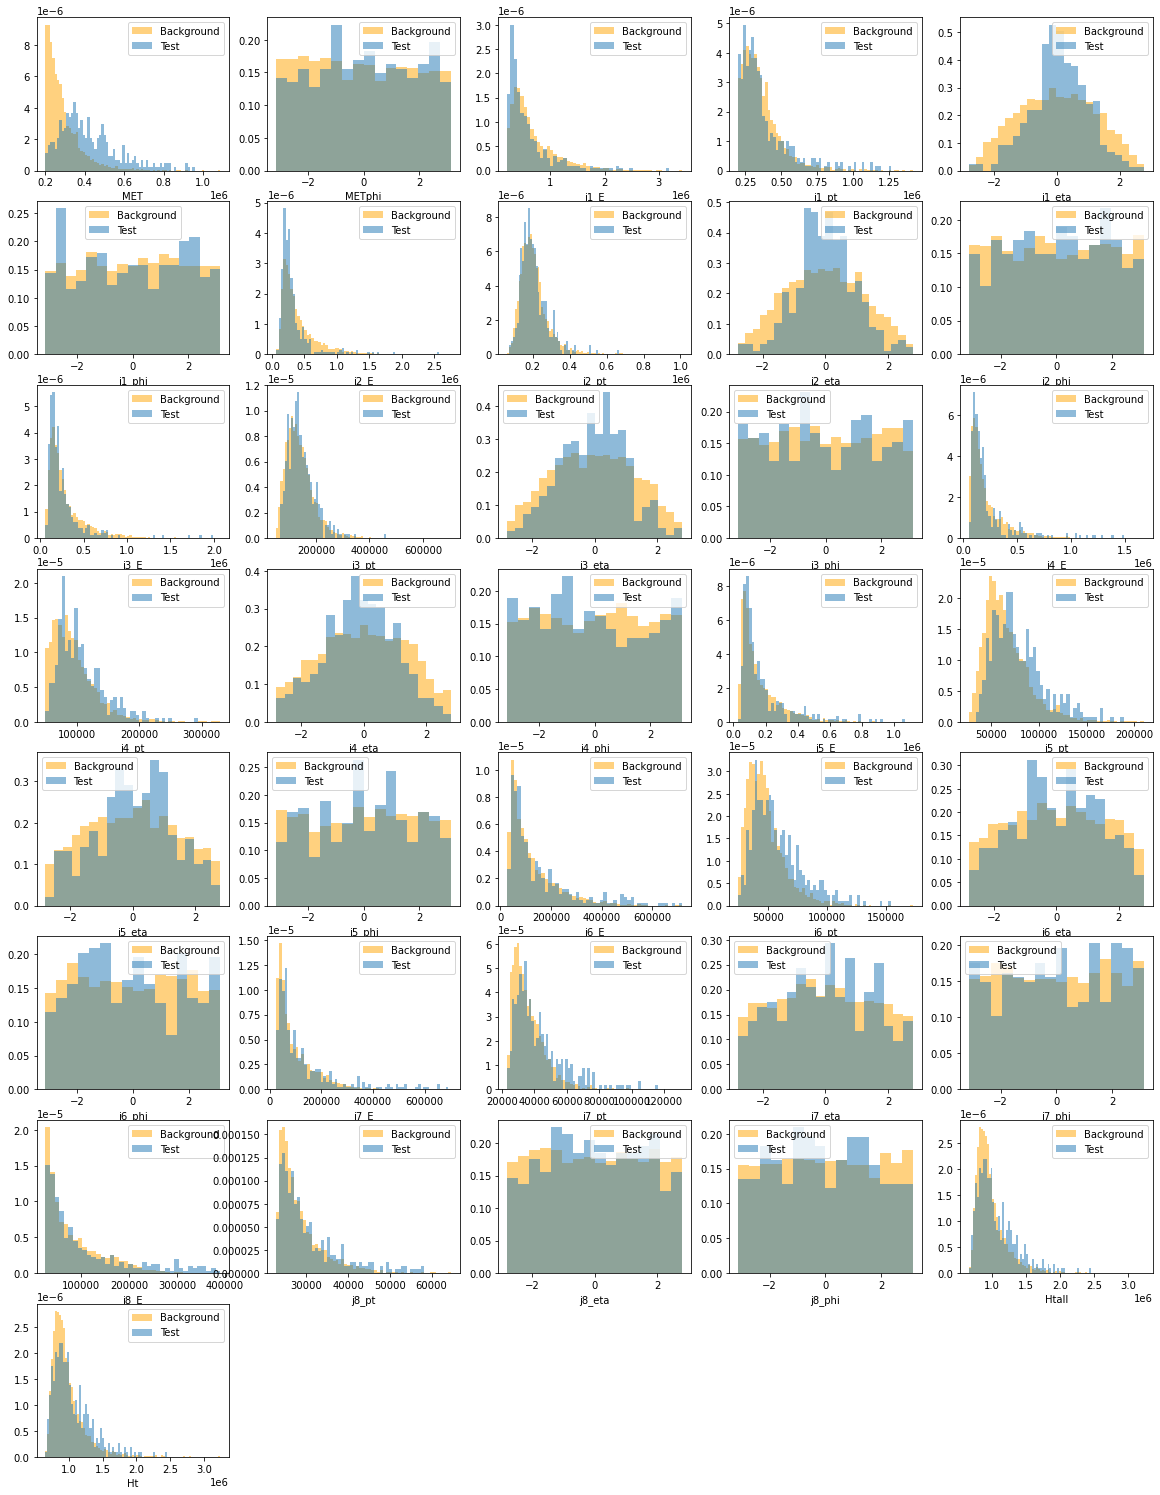

In [17]:
print("Original Images")
plt.figure(figsize=(20, 40))
for i in range(x_test.shape[1]):
    plt.subplot(12, 5, i+1)
    n, bins, patches = plt.hist(x_train[:,i], bins='auto', color = 'orange', alpha=0.5, label='Background', density=1, log=False)
    plt.hist(x_test[:,i], bins, alpha=0.5, label='Test', density=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')
    
plt.savefig('images/%s/Original_variables.png' % selname)

# Optional: Apply KDE to invmass

https://scikit-learn.org/stable/modules/density.html

https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py

## Optional: Calculate weights for all data

For this we use the densities calculated for a range a values (X_plot) since kde.score.samples takes to long to run on all training sample

## Rescale data

In [18]:
# Rescale data
#-------------
scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = Normalizer()
#scaler = QuantileTransformer(output_distribution='normal', random_state=0)
#scaler = QuantileTransformer(output_distribution='uniform', random_state=0)
#scaler = MaxAbsScaler()
#scaler = PowerTransformer()

# fit (get min and max) and transform x_train
x_train = scaler.fit_transform(x_train)

# transform x_test (using scale parameters of x_train)
x_test = scaler.transform(x_test)

print('Trial sample size: ',x_test.shape)
print('Benchmark sample size: ',x_train.shape)

Trial sample size:  (377, 36)
Benchmark sample size:  (4000, 36)


## Partition training data

In [19]:
# After all of this, it's important to partition the data. In order for your model to generalize well, 
# you split the training data into two parts: a training and a validation set. 
# You will train your model on 80% of the data and validate it on 20% of the remaining training data. 

from sklearn.model_selection import train_test_split

x_train_train,x_train_valid = train_test_split(x_train,test_size=0.2,random_state=13) 

# TEST: Split weight function for reweighted training
#x_train_train,x_train_valid, weights_train, weights_valid = train_test_split(x_train,weights,test_size=0.2,random_state=13) 

print(x_train_train.shape)
print(x_train_valid.shape)

(3200, 36)
(800, 36)


# Load the Dataset
We shuffle the loading process of train_dataset to make the learning process independent of data orderness, but the order of test_loader remains to examine whether we can handle unspecified bias order of inputs.

## Optional: train with weighted events

Uncomment below and make sure weights are calculated (see above)

## Normal training (no weights)

Uncomment below

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=x_train_train,
                                          batch_size=batch_size,
                                          shuffle=True)

## Validation and test samples

In [21]:
# validation sample
valid_loader = torch.utils.data.DataLoader(dataset=x_train_valid,
                                          batch_size=batch_size,
                                          shuffle=True)

# For testing (shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=x_test,
                                          batch_size=batch_size,
                                          shuffle=False)

# For testing on all training sample (shuffle=False)
train_all_loader = torch.utils.data.DataLoader(dataset=x_train,
                                          batch_size=batch_size,
                                          shuffle=False)


# AutoEncoder model

picked from here: https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py

About batch normalization and dropout:
* See: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd
* https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
* https://pytorch.org/docs/stable/nn.html#batchnorm1d
* dropout is applied each time forward is called, i.e, for each batch
* dropout can be applied on each layer (input, hidden, output)

About weight initialization
* Type of initialization: https://pytorch.org/docs/stable/nn.init.html#nn-init-doc
* Default initialization (here for nn.Linear): https://pytorch.org/docs/stable/nn.html#torch.nn.Linear

In [22]:
input_dim = x_train.shape[1]

#p_dropout = 0.2 # probability to zero each tensor elements

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_layer1),
            #nn.ReLU(),
            nn.Sigmoid(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_layer1, encoding_dim),
            #nn.ReLU()
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_layer1),
            #nn.ReLU(),
            nn.Sigmoid(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_layer1,input_dim),
            #nn.Sigmoid()
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Load previously trained model

# Training
Notes:

* Implementing own loss-function:
https://cs230-stanford.github.io/pytorch-getting-started.html#loss-function

* About regularization
https://discuss.pytorch.org/t/how-to-create-compound-loss-mse-l1-norm-regularization/17171

epoch [1/500], train loss:0.2909, validation loss:0.2933
epoch [100/500], train loss:0.0417, validation loss:0.0424
epoch [200/500], train loss:0.0396, validation loss:0.0413
epoch [300/500], train loss:0.0365, validation loss:0.0380
epoch [400/500], train loss:0.0327, validation loss:0.0342
epoch [500/500], train loss:0.0302, validation loss:0.0315
Final train loss value: 0.0302
time=0:00:11.996763



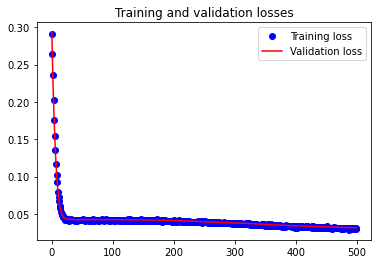

In [23]:
begin = datetime.now()

# Settings
if (use_gpu):
    model = autoencoder().cuda() # enable GPU
else:
    model = autoencoder()

# Loss function: https://pytorch.org/docs/master/nn.html#loss-functions
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay = l2_norm)

# Train
train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data in train_loader:
        data = data.type(dtype)
        
        output = model(data)
        
        # Optional: add noise to input data
        # output = model(torch.clamp(add_noise(data,scale),0,1))
        
        # Optional: set random input variables to zero
        # output = model(data_with_zeros(data))
        
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    train_loss.append(loss.item())
    #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data in valid_loader:
        data = data.type(dtype)
        
        output = model(data)

        # Optional: add noise to input data
        # output = model(torch.clamp(add_noise(data,scale),0,1))
        
        # Optional: set random input variables to zero
        # output = model(data_with_zeros(data))

        loss = criterion(output, data)
    # record validation loss
    valid_loss.append(loss.item())    
    
    if (epoch==0 or (epoch+1)%100==0):
        print('epoch [{}/{}], train loss:{:.4f}, validation loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss[-1],valid_loss[-1]))
    
print('Final train loss value: %.4f' % train_loss[-1])

# Plot model performance
epochs = range(num_epochs)
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'r-', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

end = datetime.now()
print('time={}'.format(end-begin))
print('')

### Look at NN weights
See also: https://towardsdatascience.com/everything-you-need-to-know-about-saving-weights-in-pytorch-572651f3f8de

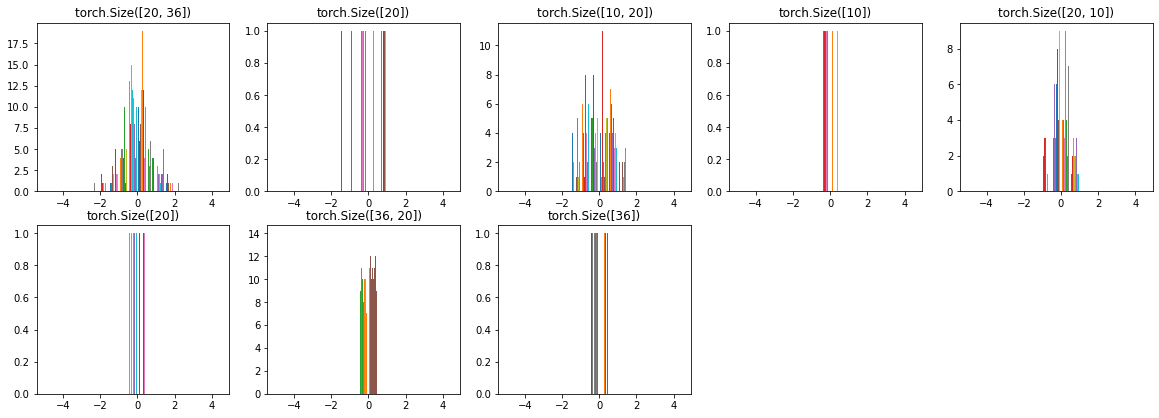

In [24]:
plt.figure(figsize=(20,18))
i=0
for param in model.parameters():
    #print(param.data)
    i+=1
    plt.subplot(5, 5, i)
    bins = np.arange(-5, 5, 0.5)
    plt.hist(param.data.cpu(), bins=bins)
    plt.title(param.data.shape)

## Calculate distances on test and train data
Calculate L2 norm of train and test samples


In [25]:
model.eval() # Sets the module in evaluation mode.

model.cpu()  # Moves all model parameters and buffers to the CPU to avoid out of memory

train_encoded = []
train_decoded = []
train_norm = []

for data in train_all_loader:
    data = data.type(dtype).cpu().detach()
    train_encoded += [model.encoder(data)]
    train_decoded += [model(data)]
    train_norm    += [model(data) - data]

train_latence = torch.cat(train_encoded).cpu().detach().numpy()
train_output  = torch.cat(train_decoded).cpu().detach().numpy()
train_distance = torch.norm(torch.cat(train_norm),dim=1)
#train_distance = torch.max(torch.cat(train_norm),dim=1)[0]


In [26]:
test_encoded = []
test_decoded = []
test_norm = []

for data in test_loader:
    data = data.type(dtype).cpu().detach()
    #data = data.type(dtype)
    test_encoded += [model.encoder(data)]
    test_decoded += [model(data)]
    test_norm    += [model(data) - data]

test_latence = torch.cat(test_encoded).cpu().detach().numpy()
test_output  = torch.cat(test_decoded).cpu().detach().numpy()
test_distance = torch.norm(torch.cat(test_norm),dim=1)
#test_distance = torch.max(torch.cat(test_norm),dim=1)[0]

In [27]:
# Convert tensors to numpy arrays
norm_test  = test_distance.cpu().detach().numpy()
norm_train = train_distance.cpu().detach().numpy()

## Show plot of distances


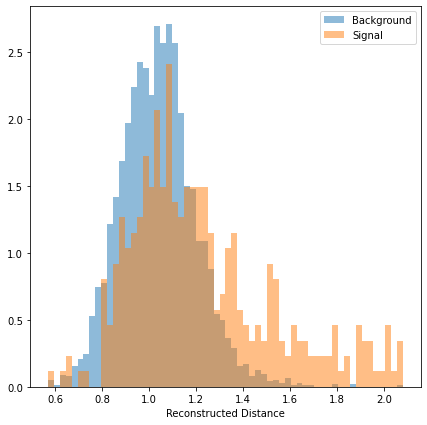

In [28]:
#bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(7, 7))
#n, bins, patches = plt.hist(norm_test, bins='auto', alpha=0.5, label='Signal', density=1)
#plt.hist(norm_train, bins, alpha=0.5, label='Background', density=1, log=False)

n, bins, patches = plt.hist(norm_train, bins='auto', alpha=0.5, label='Background', density=1)
plt.hist(norm_test, bins, alpha=0.5, label='Signal', density=1, log=False)

plt.xlabel('Reconstructed Distance')
plt.legend(loc='upper right')
#plt.savefig("images/distances.png")

#plt.xlim(0,0.4)

## ROC Curve

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

def ROC(var_train,var_test):
    target = np.concatenate((np.zeros(var_train.shape[0]),np.ones(var_test.shape[0])))
    scores = np.concatenate((var_train,var_test))  
    fp, vp, thresholds = roc_curve(target,scores,pos_label=1)
    roc_auc = auc(fp, vp)
    return fp, vp, thresholds, roc_auc

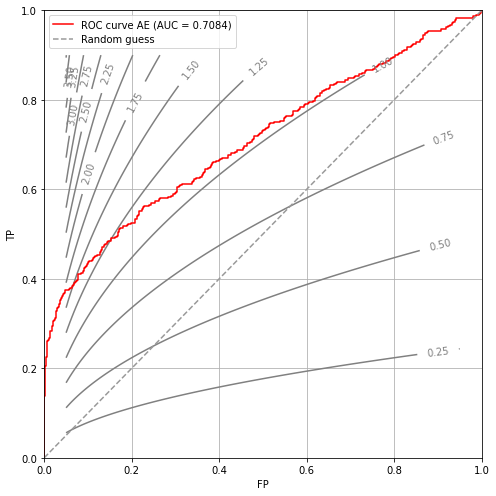

In [30]:
fp, vp, thresholds, roc_auc = ROC(norm_train,norm_test)

plt.figure(figsize=(7, 7))
plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))
plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
#plt.plot([0, 0, 1],[0, 1, 1],color='yellow',label='Idéal')
plt.grid()

# Optional: show significance variation curves
#---------------------------------------------
"""
def fsig(x,beta):
    # significance-after-cut = sig * TP / sqrt(FP)
    # x: variation of significance after threshold
    # beta = FP (i.e fraction of surviving background)
    return x*np.sqrt(beta)
beta = np.linspace(0,1,100)
x=1.0; plt.plot(beta,fsig(x,beta),linestyle='dotted',color='grey',lw=2,label=r'$S/\sqrt{B} \times$ %.1f' % x)
x=1.1; plt.plot(beta,fsig(x,beta),linestyle='dashdot',color='grey',lw=1,label=r'$S/\sqrt{B} \times$ %.1f' % x)
x=1.2; plt.plot(beta,fsig(x,beta),linestyle='dashed',color='grey',lw=1,label=r'$S/\sqrt{B} \times$ %.1f' % x)
plt.ylim(0,1)
"""

# Alternative plot
# https://kmdb.pagesperso-orange.fr/_src/_python/_formation_2010/python_formation_matplotlib.html
def fsig2(alpha,beta):
    # significance variation: alpha/sqrt(beta)
    # alpha = TP, beta = FP
    return alpha/np.sqrt(beta)

alpha , beta = np.meshgrid(np.linspace(0.05,0.90,201),np.linspace(0.05,0.95,201))
z = fsig2(alpha,beta)
graph = plt.contour(beta,alpha,z,15,colors='grey')
plt.clabel(graph,inline=1,fontsize=10,fmt='%3.2f')
plt.xlim(0,1)
plt.ylim(0,1)

plt.legend(loc="best")
plt.tight_layout()
#plt.savefig("images/ROC.png")

## Optional: plot significance variation vs threshold

[0.0000e+00 0.0000e+00 0.0000e+00 2.5000e-04 2.5000e-04 7.5000e-04
 7.5000e-04 1.0000e-03 1.0000e-03 1.2500e-03 1.2500e-03 1.5000e-03
 1.5000e-03 1.7500e-03 1.7500e-03 2.0000e-03 2.0000e-03 2.5000e-03
 2.5000e-03 4.0000e-03 4.0000e-03 4.5000e-03 4.5000e-03 4.7500e-03
 4.7500e-03 5.2500e-03 5.2500e-03 5.5000e-03 5.5000e-03 6.0000e-03
 6.0000e-03 6.5000e-03 6.5000e-03 7.0000e-03 7.0000e-03 7.5000e-03
 7.5000e-03 7.7500e-03 7.7500e-03 1.0000e-02 1.0000e-02 1.1250e-02
 1.1750e-02 1.3000e-02 1.3000e-02 1.3250e-02 1.3250e-02 1.3500e-02
 1.3500e-02 1.4250e-02 1.4250e-02 1.6750e-02 1.6750e-02 1.7500e-02
 1.7500e-02 1.8750e-02 1.8750e-02 1.9500e-02 1.9500e-02 2.0000e-02
 2.0000e-02 2.0250e-02 2.0250e-02 2.3500e-02 2.3500e-02 2.3750e-02
 2.3750e-02 2.5250e-02 2.5250e-02 2.6250e-02 2.6250e-02 2.6750e-02
 2.6750e-02 2.7000e-02 2.7000e-02 2.7750e-02 2.7750e-02 2.8500e-02
 2.8500e-02 3.0000e-02 3.0000e-02 3.1250e-02 3.1250e-02 3.3000e-02
 3.3000e-02 3.4000e-02 3.4000e-02 3.5000e-02 3.5000e-02 3.5250

/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, '$S/\\sqrt{B}$ variation after threshold')

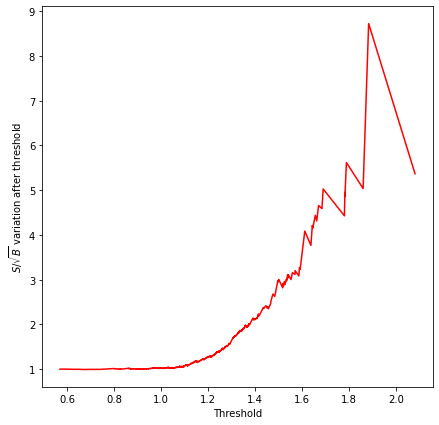

In [31]:
print(fp, vp, thresholds)
s=np.divide(vp,np.sqrt(fp))
plt.figure(figsize=(7, 7))
plt.plot(thresholds,s,color='red',label='bla')
plt.xlabel('Threshold')
plt.ylabel(r'$S/\sqrt{B}$ variation after threshold')

## Save some output files

### Check output

### Check variable reconstruction

Train variables: true and reco


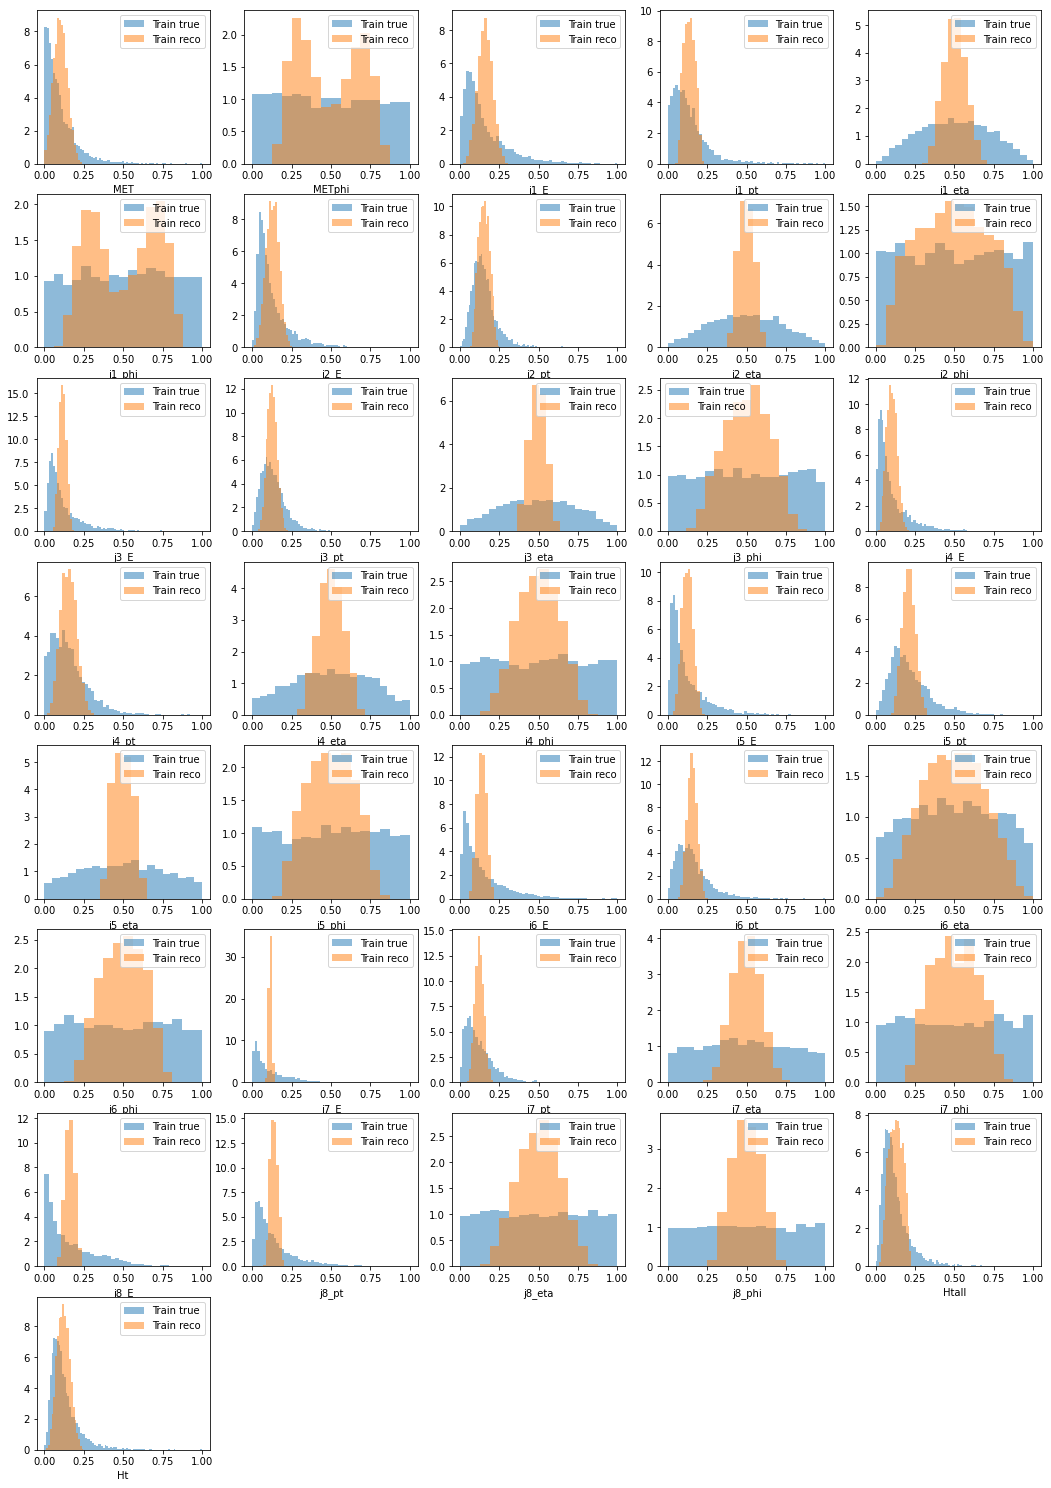

In [32]:
#bins = np.arange(0, 1, 0.01)

print("Train variables: true and reco")
plt.figure(figsize=(18, 40))
for i in range(x_test.shape[1]):
    plt.subplot(12, 5, i+1)
    n, bins, patches = plt.hist(x_train[:,i], bins='auto', alpha=0.5, label='Train true', density=1)
    n, bins, patches = plt.hist(train_output[:,i], bins, alpha=0.5, label='Train reco', density=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')
    
#plt.savefig('images/train_variables_true_reco.png')

Test variables: true and reco


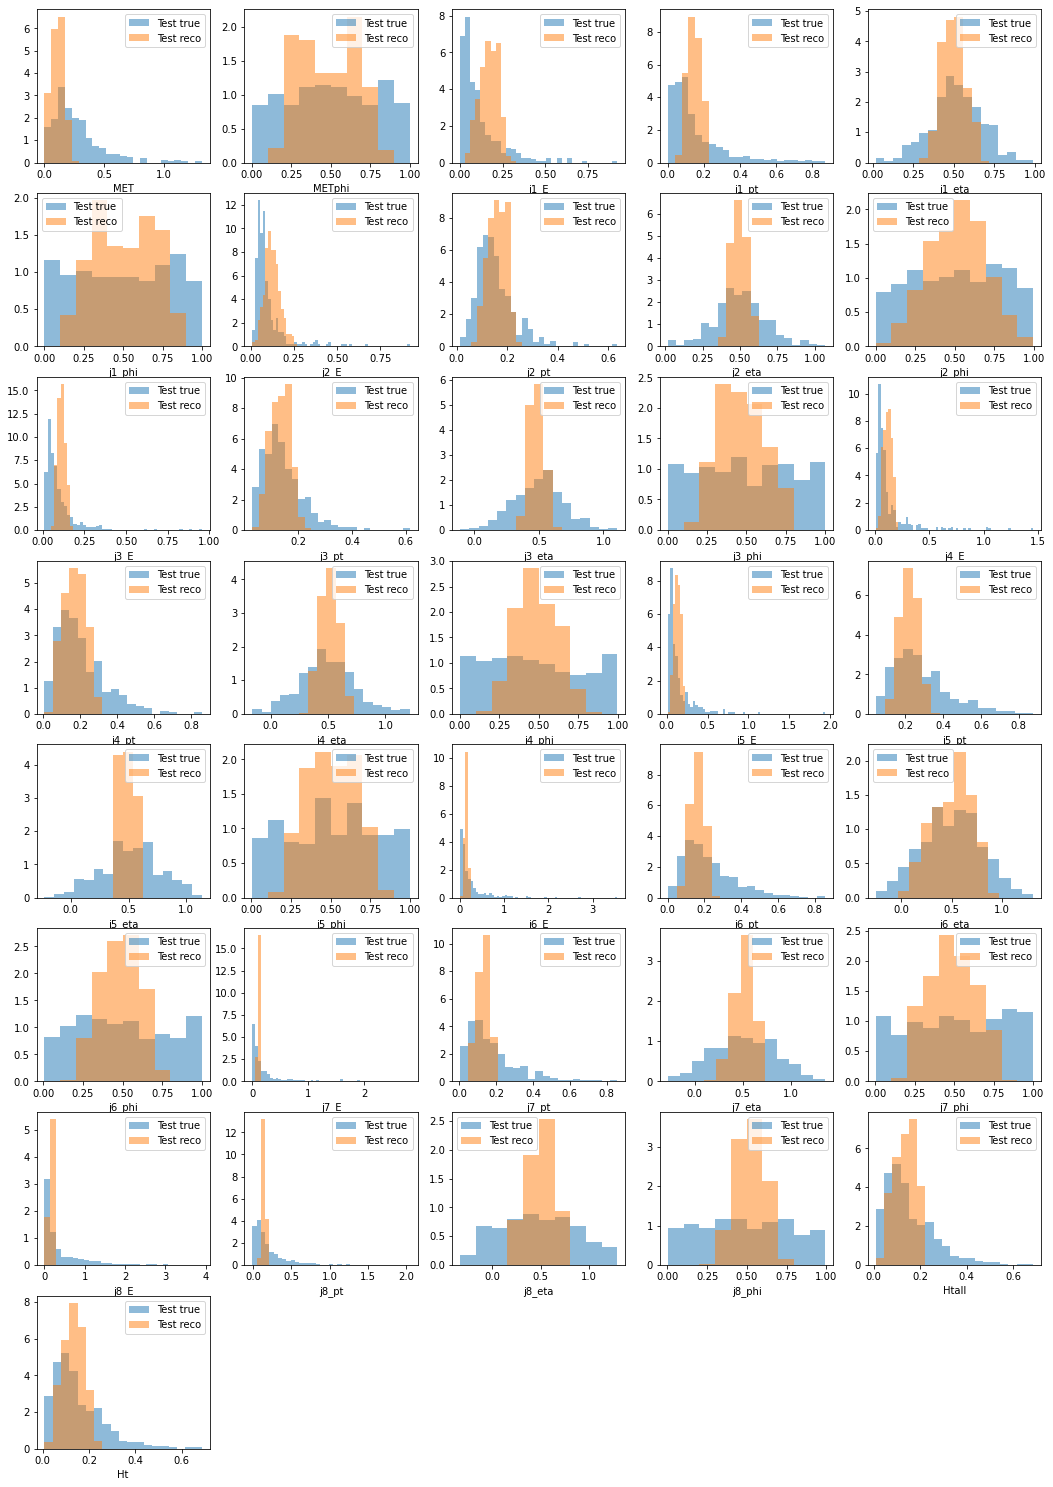

In [33]:
print("Test variables: true and reco")
plt.figure(figsize=(18, 40))
for i in range(x_test.shape[1]):
    plt.subplot(12, 5, i+1)
    n, bins, patches = plt.hist(x_test[:,i], bins='auto', alpha=0.5, label='Test true', density=1)
    n, bins, patches = plt.hist(test_output[:,i], bins, alpha=0.5, label='Test reco', density=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')
    
#plt.savefig('images/test_variables_true_reco.png')

# Apply AE to other signals

In [34]:
roc_results={}
distances = {}

for s in sig:
    print(s)
    signal_sel = sig[s]
    signal_sel = scaler.transform(signal_sel.loc[:,features_sel])
    sss=torch.tensor(signal_sel).type(dtype).cpu().detach()
    out = model(sss)
    norm_test = torch.norm((out-sss),dim=1).cpu().detach().numpy()
    fp, vp, thresholds, roc_auc = ROC(norm_train,norm_test)
    roc_results[s] = [fp,vp,roc_auc,thresholds]
    distances[s] = norm_test

glgl1400_neutralino1100
glgl1600_neutralino800
monojet_Zp2000.0
monotop_200
sqsq1_sq1400
sqsq_sq1800
stlp_st1000
stop2b1000_neutralino300


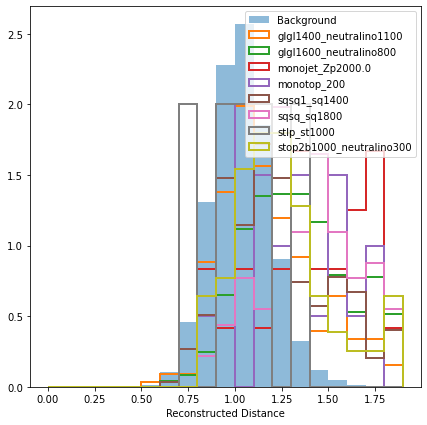

In [35]:
bins = np.arange(0, 2, 0.1)
plt.figure(figsize=(7, 7))
#n, bins, patches = plt.hist(norm_train, bins='auto', alpha=0.5, label='Background', density=1)
n, bins, patches = plt.hist(norm_train, bins=bins, alpha=0.5, label='Background', density=1)
for s in sig:
    plt.hist(distances[s], bins, alpha=1, label=s, density=1, histtype = 'step',linewidth=2,log=False)

plt.xlabel('Reconstructed Distance')
plt.legend(loc='upper right')
plt.savefig('images/%s/distances-allsignals_input%d_hidden%d_latence%d_ne%d_bs%d_%s_chan1.pdf' % (selname,input_dim,hidden_layer1,encoding_dim,num_epochs,batch_size,selname))

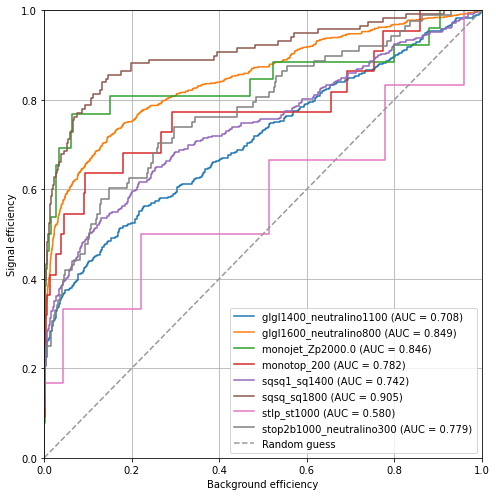

In [36]:
plt.figure(figsize=(7, 7))
for s in sig:
    plt.plot(roc_results[s][0],roc_results[s][1],label='%s (AUC = %0.3f)'%(s,roc_results[s][2]))
plt.xlabel('Background efficiency') # FP
plt.ylabel('Signal efficiency') # TP
plt.plot([0, 1],[0, 1], linestyle='--',color=(0.6, 0.6, 0.6), label='Random guess')
plt.grid()
alpha , beta = np.meshgrid(np.linspace(0.05,0.90,201),np.linspace(0.05,0.95,201))
z = fsig2(alpha,beta)
#graph = plt.contour(beta,alpha,z,15,colors='grey')
#plt.clabel(graph,inline=1,fontsize=10,fmt='%3.2f')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc="best")
plt.tight_layout()

plt.savefig('images/%s/roc-allsignals_input%d_hidden%d_latence%d_ne%d_bs%d_%s_chan1.pdf' % (selname,input_dim,hidden_layer1,encoding_dim,num_epochs,batch_size,selname))

/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide

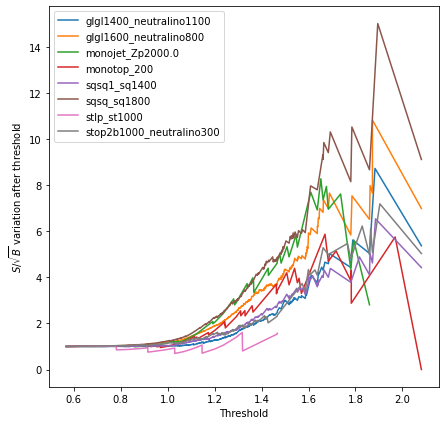

In [37]:
plt.figure(figsize=(7, 7))
for s in sig:
    fp, vp, thresholds = roc_results[s][0], roc_results[s][1], roc_results[s][3]
    S=np.divide(vp,np.sqrt(fp))
    plt.plot(thresholds,S,label=s)
plt.legend(loc='upper left')
plt.xlabel('Threshold')
plt.ylabel(r'$S/\sqrt{B}$ variation after threshold')
plt.savefig('images/%s/significance_input%d_hidden%d_latence%d_ne%d_bs%d_%s_chan1.pdf' % (selname,input_dim,hidden_layer1,encoding_dim,num_epochs,batch_size,selname))

/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide

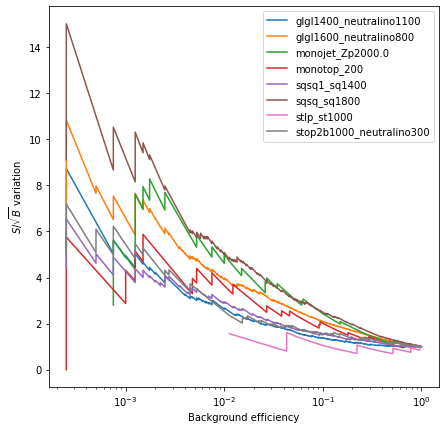

In [38]:
plt.figure(figsize=(7, 7))
for s in sig:
    fp, vp, thresholds = roc_results[s][0], roc_results[s][1], roc_results[s][3]
    S=np.divide(vp,np.sqrt(fp))
    plt.plot(fp,S,label=s)
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel('Background efficiency')
plt.ylabel(r'$S/\sqrt{B}$ variation')
plt.savefig('images/%s/significance2_input%d_hidden%d_latence%d_ne%d_bs%d_%s_chan1.pdf' % (selname,input_dim,hidden_layer1,encoding_dim,num_epochs,batch_size,selname))

## Print out results

Format of ouput:
* signature, 
* background name, Nb (total in this channel), 
* process-name, Ns (total in this channel, no weights)
* signal efficiency for 50%, 10%, 1%, 0.1% background efficiency


In [39]:
b='background_chan1' # background name
Nb = bkg[b].shape[0]
line = selname
line += ", %s, %d" % (b, Nb)
for s in sig:
    Ns = sig[s].shape[0]
    fp, vp, thresholds = roc_results[s][0], roc_results[s][1], roc_results[s][3]
    line += ", %s, %d, %.4f, %.4f, %.4f, %.4f" % (s, Ns, vp[fp>0.5][0],vp[fp>0.1][0],vp[fp>0.01][0],vp[fp>0.001][0])
line += "\n"
print(line)

8j0b0e0m0g, background_chan1, 4000, glgl1400_neutralino1100, 377, 0.7321, 0.4324, 0.2679, 0.1565, glgl1600_neutralino800, 824, 0.8738, 0.6614, 0.3981, 0.2063, monojet_Zp2000.0, 26, 0.8462, 0.7692, 0.5000, 0.1538, monotop_200, 22, 0.7727, 0.6364, 0.3636, 0.1364, sqsq1_sq1400, 329, 0.7568, 0.4924, 0.2948, 0.1337, sqsq_sq1800, 118, 0.9237, 0.7881, 0.5085, 0.2881, stlp_st1000, 6, 0.5000, 0.3333, 0.1667, 0.1667, stop2b1000_neutralino300, 88, 0.8068, 0.4773, 0.2500, 0.1705



In [40]:
f = open('txt/signal_efficiencies.txt', 'a')
f.write(line)
f.close()

# Save the model for future implementations

In [41]:
torch.save(model.state_dict(), 'models/%s/AE_input%d_hidden%d_latence%d_ne%d_bs%d_%s_chan1.pkl' % (selname,input_dim,hidden_layer1,encoding_dim,num_epochs,batch_size,selname))